<a href="https://colab.research.google.com/github/ParalelaUnsaac/G3-2020-1/blob/main/ProyectoParalela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diagrama de Flujo


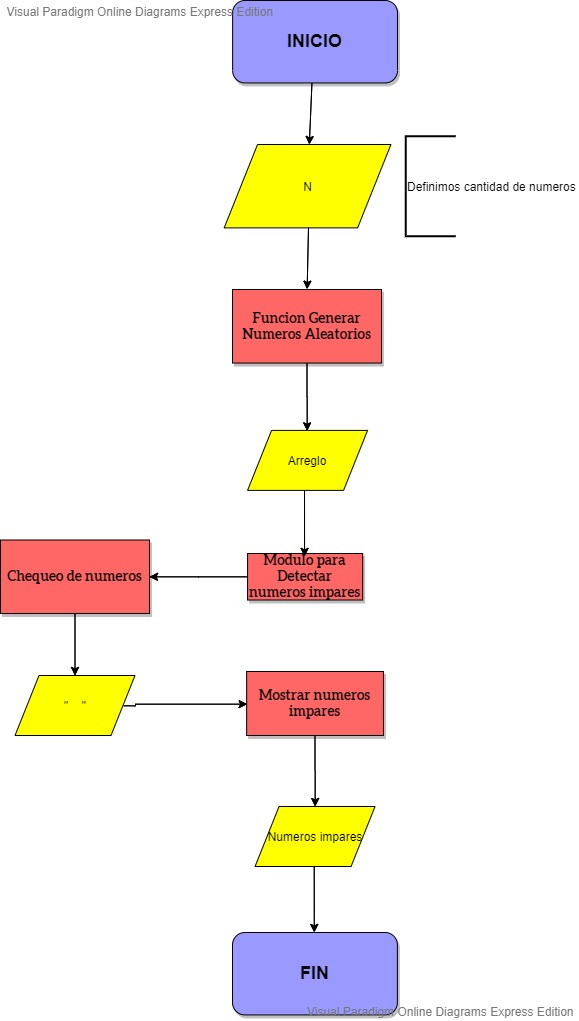

Codificacion

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
(Reading database ... 122374 files and directories currently installed.)
Removing cuda-command-line-tools-10-1 (10.1.243-1) ...
dpkg: dependency problems prevent removal of cuda-cublas-10-0:
 cuda-cublas-dev-10-0 depends on cuda-cublas-10-0 (>= 10.0.130).

dpkg: error processing package cuda-cublas-10-0 (--purge):
 dependency problems - not removing
Errors were encountered while processing:
 cuda-cublas-10-0
dpkg: dependency problems prevent removal of cuda-cublas-dev-10-0:
 cuda-libraries-dev-10-0 depends on cuda-cublas-dev-10-0 (>= 10.0.130).

dpkg: error processing package cuda-cublas-dev-10-0 (--purge):
 dependency problems - not removing
Errors were encountered while processing:
 cuda-cublas-dev-10-0
dpkg: dependency problems prevent removal of cuda-cudart-10-0:
 cuda-cudart-dev-10-0 depends on cuda-cudart-10-0 (>= 10.0.130).

dpkg: error processing package cuda-cudart-10-0 (--purge):
 de

In [ ]:
!nvidia-smi

Tue Oct 27 03:57:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%cu
//cuda_runtime_api.h define los funciones y tipos de host públicos para la API CUDA tiempo de ejecución
//cuda_runtime.h define todo cuda_runtime_api.h hace, asi como de tipo incorporado definiciones y superposiciones de funciones para las extensiones de lenguaje CUDA y funciones intrínsecas dispositivo.
#include "cuda_runtime.h"
//Importa / Incluye las funciones, constantes y macros desde la librería de Entrada / Salida estándard (standar input/output
//los periféricos estándar son, monitor, teclado, discoduro, impresora … y esta librería te permite leer desde o enviar información hacia estos periféricos
//como leer variables de ese teclado, o enviar una texto a un archivo en disco.
#include <stdio.h>
//Es el archivo de cabecera de la biblioteca estándar de propósito general de el lenguaje de programación C. Contiene los prototipos de funciones de C para gestión de memoria dinámica, control de procesos y otras. Es compatible con C++ donde se conoce como cstdlib.
#include <stdlib.h>
//cuda.h define el host público funciones y tipos para la API de controlador CUDA
#include <cuda.h>

#define MAXVALUE 10000

//------------------------------------
void numberGen(int N, int max, int* store) //Funcion generar numeros
{
    //Declarando variable entero i
    int i;
    //Tiempo para generar numeros aleatorios
    srand(time(0));
    for (i = 0; i < N; i++)//For para recorrer los numeros
        store[i] = rand() % max; //Almacena en el arreglo
}
//------------------------------------
//Funcion __global__ que se puede llama r desde el host, y se ejecuta en el dispositivo
__global__ void countOdds(int* d, int N, int* odds)
{   
    //Asignamos memoria compartida dinamicamente(extern significa que la matriz hace referencia a la memoria compartida declarada en otro lugar)
    extern __shared__ int count[];

    int myID = blockIdx.x * blockDim.x + threadIdx.x;//Añadiendo el tamaño del grid y del bloque
    int localID = threadIdx.x; // Ponemos el id en cada hilo
    count[localID] = 0;
    if (myID < N)
        count[localID] = (d[myID] % 2); //Un modulo paran detectar si es par o impar
    __syncthreads(); //Sincroniza los subprocesos locales escribiendo en la memoria caché

    // fase de reducción
    int step = 1;
    while (((localID | step) < blockDim.x) && ((localID & step) == 0))
    {
        count[localID] += count[localID | step];
        step <<= 1;
        __syncthreads();
    }

   
    // adiciona al contador global
    if (localID == 0)
        atomicAdd(odds, count[0]);
}

//------------------------------------
int sharedSize(int b)
{
    return b * sizeof(int);
}

//------------------------------------

int main(int argc, char** argv)
{
    //Definimos la cantidad de numeros que se genera aleatoriamente
    int N = 50000;
    //Define punteros host(h*) y device (d*)
    int* ha, * hres, * da, * dres;   // punteros host (h*) y device (d*)

    ha = new int[N];//Declaramos un arreglo en la variable ha
    hres = new int[1];//Declaramos un arreglo en la variable hres
 
    //Almacena un espacio en la memoria da
    cudaMalloc((void**)&da, sizeof(int) * N);
    //Almacena un espacio en la memoria para dres
    cudaMalloc((void**)&dres, sizeof(int) * 1);
 
    //Llama a la funcion numbeGen()
    numberGen(N, MAXVALUE, ha);

    cudaMemcpy(da, ha, sizeof(int) * N, cudaMemcpyHostToDevice);//Copia datos a la memoria del dispositivo
    cudaMemset(dres, 0, sizeof(int));//llenamos los primeros bytes de recuento del área de memoria apuntada por dres con el valor de byte valor constante.

    int blockSize, gridSize;
 
    //Devuelve el tamaño de cuadrícula y bloque que logra la máxima ocupación potencial para una función de dispositivo.
    cudaOccupancyMaxPotentialBlockSizeVariableSMem(&gridSize, &blockSize, (void*)countOdds, sharedSize, N);

    gridSize = ceil(1.0 * N / blockSize);
    printf("Grid : %i    Block : %i\n", gridSize, blockSize);
    countOdds << < gridSize, blockSize, blockSize * sizeof(int) >> > (da, N, dres);

    //Copia datos a la memoria del dispostivo
    cudaMemcpy(hres, dres, sizeof(int), cudaMemcpyDeviceToHost);

   // chequeo
    int oc = 0;
    for (int i = 0; i < N; i++)//Hcae un recorrido
        if (ha[i] % 2){
            printf("%i ",ha[i]);
            oc++;
        }
    printf("");
    //Imprime cantidad de numeros imapres en el arreglo
    printf("\nCantidad de numeros impares - Chequeo\n");
    printf("%i %i\n", *hres, oc);
    cudaFree((void*)da);//Libera memoria de da
    cudaFree((void*)dres);//Libera memoria de dres
 
    delete[]ha; //Operacion eliminar ha
    delete[]hres;//Operacion eliminar hres
    cudaDeviceReset();//Libreria contexto de cuda, quita las asignaciones de todo los dispositivos
    getchar();
    return 0;
}

Grid : 49    Block : 1024
2133 4371 5559 9485 331 9297 3229 5381 473 1037 2489 4601 1639 855 4379 8349 5285 6379 2217 6575 891 1957 8339 5205 8353 7441 1781 5837 101 41 7751 627 6379 6431 3445 5583 1769 3245 3283 4137 7631 6065 8803 6629 6607 6709 3001 7185 5267 2343 8051 8987 1257 1841 7161 4587 325 261 8565 6539 6413 8631 5847 9963 3033 9343 1371 6351 1389 8551 3139 7957 2397 349 133 6983 2899 9283 8131 4979 5111 9135 3335 967 8811 5277 4915 3983 401 9271 5109 7467 1001 6099 2423 4231 917 7015 4975 8865 5743 5365 5063 3119 3157 8353 1539 5861 7843 1961 2425 6031 5911 4669 8651 8413 6765 4017 603 113 8407 4899 3549 6439 307 9439 8113 3555 4677 7163 4733 3195 9333 1445 1801 6211 8353 3099 6927 8179 1407 1761 4057 3965 9619 7027 2789 399 2201 4345 6797 7119 6891 9483 7847 415 7895 6895 3043 1275 3443 7635 5467 1031 1923 275 7051 3011 1549 4603 3925 8621 2499 1459 7761 9807 5275 3477 7313 3779 9729 8007 3229 7831 8919 5087 1285 2259 5557 1411 5467 9173 5297 5267 8451 5895 7805 5625 695 9